## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Data preprocessing

In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        trace_df=trace_df.drop(['wifi_val1'], axis=1)
        trace_df=trace_df.drop(['wifi_val2'], axis=1)
        trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#1 trace test Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/test/'
trace_values=(convert_to_df(file_path,0))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
len(sequences)

98

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,100))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 2197
Number of targets 2197
Number of timeslots in first sequence 100
Number of timeslots in tenth sequence 100
Number of timeslots in hundredth sequence 100


In [ ]:
#Now adding data of other floors to the sequences starting with F1
file_path = '/content/drive/MyDrive/building1/data/F1'
trace_values=(convert_to_df(file_path,1,100))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F2'
trace_values=(convert_to_df(file_path,2,100))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F3'
trace_values=(convert_to_df(file_path,3,100))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F4'
trace_values=(convert_to_df(file_path,4,100))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 11084
Number of targets 11084
Number of timeslots in first sequence 100
Number of timeslots in tenth sequence 100
Number of timeslots in hundredth sequence 100


In [ ]:
target_sequence[0]

0

In [ ]:
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)
flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

11084

In [ ]:
train = [sequences[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)

train_target=to_categorical(train_target,num_classes = 5)

validation_target = np.array(validation_target)

validation_target=to_categorical(validation_target,num_classes = 5)

test_target = np.array(test_target)

test_target=to_categorical(test_target,num_classes = 5)

In [ ]:
print(sequences[0].shape)
train_target.shape

(100, 24)


(7758, 5)

In [ ]:
seq_len = 100
seq_bredth=24
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, seq_bredth)))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               287744    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 321,285
Trainable params: 321,285
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)


In [ ]:
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
61/61 [==============================] - 48s 755ms/step - loss: 1.1120 - accuracy: 0.4938 - val_loss: 0.7089 - val_accuracy: 0.6715

Epoch 00001: val_accuracy improved from -inf to 0.67148, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 2/200
61/61 [==============================] - 46s 761ms/step - loss: 0.6491 - accuracy: 0.6938 - val_loss: 0.5842 - val_accuracy: 0.7310

Epoch 00002: val_accuracy improved from 0.67148 to 0.73105, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 3/200
61/61 [==============================] - 46s 760ms/step - loss: 0.5148 - accuracy: 0.7663 - val_loss: 0.4717 - val_accuracy: 0.7996

Epoch 00003: val_accuracy improved from 0.73105 to 0.79964, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 4/200
61/61 [==============================] - 47s 768ms/step - loss: 0.4503 - accuracy: 0.7927 - val_loss: 0.4290 - val_accuracy: 0.7948

Epoch 00004: val_accuracy did not improve from 0.79964
Epoch 5/200
61/61 [==============================] - 48s 780ms/step - loss: 0.4067 - accuracy: 0.8239 - val_loss: 0.3848 - val_accuracy: 0.8261

Epoch 00005: val_accuracy improved from 0.79964 to 0.82611, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 6/200
61/61 [==============================] - 45s 746ms/step - loss: 0.3870 - accuracy: 0.8192 - val_loss: 0.3641 - val_accuracy: 0.8369

Epoch 00006: val_accuracy improved from 0.82611 to 0.83694, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 7/200
61/61 [==============================] - 45s 741ms/step - loss: 0.3593 - accuracy: 0.8449 - val_loss: 0.3983 - val_accuracy: 0.8315

Epoch 00007: val_accuracy did not improve from 0.83694
Epoch 8/200
61/61 [==============================] - 45s 743ms/step - loss: 0.3662 - accuracy: 0.8331 - val_loss: 0.3375 - val_accuracy: 0.8484

Epoch 00008: val_accuracy improved from 0.83694 to 0.84838, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 9/200
61/61 [==============================] - 45s 736ms/step - loss: 0.3291 - accuracy: 0.8532 - val_loss: 0.3419 - val_accuracy: 0.8544

Epoch 00009: val_accuracy improved from 0.84838 to 0.85439, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 10/200
61/61 [==============================] - 45s 737ms/step - loss: 0.3130 - accuracy: 0.8580 - val_loss: 0.3122 - val_accuracy: 0.8574

Epoch 00010: val_accuracy improved from 0.85439 to 0.85740, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 11/200
61/61 [==============================] - 45s 732ms/step - loss: 0.2999 - accuracy: 0.8684 - val_loss: 0.4216 - val_accuracy: 0.8159

Epoch 00011: val_accuracy did not improve from 0.85740
Epoch 12/200
61/61 [==============================] - 44s 728ms/step - loss: 0.3437 - accuracy: 0.8475 - val_loss: 0.3337 - val_accuracy: 0.8448

Epoch 00012: val_accuracy did not improve from 0.85740
Epoch 13/200
61/61 [==============================] - 45s 734ms/step - loss: 0.2893 - accuracy: 0.8703 - val_loss: 0.3619 - val_accuracy: 0.8363

Epoch 00013: val_accuracy did not improve from 0.85740
Epoch 14/200
61/61 [==============================] - 44s 729ms/step - loss: 0.3143 - accuracy: 0.8589 - val_loss: 0.3305 - val_accuracy: 0.8646

Epoch 00014: val_accuracy improved from 0.85740 to 0.86462, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 15/200
61/61 [==============================] - 44s 727ms/step - loss: 0.3017 - accuracy: 0.8660 - val_loss: 0.3189 - val_accuracy: 0.8478

Epoch 00015: val_accuracy did not improve from 0.86462
Epoch 16/200
61/61 [==============================] - 45s 730ms/step - loss: 0.2910 - accuracy: 0.8715 - val_loss: 0.3247 - val_accuracy: 0.8532

Epoch 00016: val_accuracy did not improve from 0.86462
Epoch 17/200
61/61 [==============================] - 44s 726ms/step - loss: 0.2929 - accuracy: 0.8674 - val_loss: 0.3517 - val_accuracy: 0.8544

Epoch 00017: val_accuracy did not improve from 0.86462
Epoch 18/200
61/61 [==============================] - 44s 724ms/step - loss: 0.2844 - accuracy: 0.8712 - val_loss: 0.2946 - val_accuracy: 0.8785

Epoch 00018: val_accuracy improved from 0.86462 to 0.87846, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 19/200
61/61 [==============================] - 45s 738ms/step - loss: 0.2726 - accuracy: 0.8790 - val_loss: 0.2644 - val_accuracy: 0.8839

Epoch 00019: val_accuracy improved from 0.87846 to 0.88387, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 20/200
61/61 [==============================] - 45s 735ms/step - loss: 0.2559 - accuracy: 0.8854 - val_loss: 0.2877 - val_accuracy: 0.8712

Epoch 00020: val_accuracy did not improve from 0.88387
Epoch 21/200
61/61 [==============================] - 45s 731ms/step - loss: 0.2573 - accuracy: 0.8887 - val_loss: 0.2762 - val_accuracy: 0.8857

Epoch 00021: val_accuracy improved from 0.88387 to 0.88568, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 22/200
61/61 [==============================] - 45s 740ms/step - loss: 0.2504 - accuracy: 0.8912 - val_loss: 0.3378 - val_accuracy: 0.8532

Epoch 00022: val_accuracy did not improve from 0.88568
Epoch 23/200
61/61 [==============================] - 46s 752ms/step - loss: 0.2674 - accuracy: 0.8833 - val_loss: 0.2890 - val_accuracy: 0.8839

Epoch 00023: val_accuracy did not improve from 0.88568
Epoch 24/200
61/61 [==============================] - 44s 730ms/step - loss: 0.2874 - accuracy: 0.8775 - val_loss: 0.3063 - val_accuracy: 0.8652

Epoch 00024: val_accuracy did not improve from 0.88568
Epoch 25/200
61/61 [==============================] - 44s 729ms/step - loss: 0.2666 - accuracy: 0.8828 - val_loss: 0.2510 - val_accuracy: 0.8857

Epoch 00025: val_accuracy did not improve from 0.88568
Epoch 26/200
61/61 [==============================] - 45s 738ms/step - loss: 0.2402 - accuracy: 0.8955 - val_loss: 0.2700 - val_accuracy: 0.8694

Epoch 00026: val_accuracy did not improve from 0.8

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 28/200
61/61 [==============================] - 45s 734ms/step - loss: 0.2215 - accuracy: 0.9084 - val_loss: 0.2588 - val_accuracy: 0.8869

Epoch 00028: val_accuracy did not improve from 0.88929
Epoch 29/200
61/61 [==============================] - 45s 731ms/step - loss: 0.2155 - accuracy: 0.9056 - val_loss: 0.2440 - val_accuracy: 0.8911

Epoch 00029: val_accuracy improved from 0.88929 to 0.89110, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 30/200
61/61 [==============================] - 45s 737ms/step - loss: 0.2125 - accuracy: 0.9065 - val_loss: 0.2610 - val_accuracy: 0.8821

Epoch 00030: val_accuracy did not improve from 0.89110
Epoch 31/200
61/61 [==============================] - 44s 728ms/step - loss: 0.2106 - accuracy: 0.9024 - val_loss: 0.2489 - val_accuracy: 0.8905

Epoch 00031: val_accuracy did not improve from 0.89110
Epoch 32/200
61/61 [==============================] - 45s 735ms/step - loss: 0.2153 - accuracy: 0.9035 - val_loss: 0.3209 - val_accuracy: 0.8484

Epoch 00032: val_accuracy did not improve from 0.89110
Epoch 33/200
61/61 [==============================] - 45s 741ms/step - loss: 0.2372 - accuracy: 0.8960 - val_loss: 0.2461 - val_accuracy: 0.8899

Epoch 00033: val_accuracy did not improve from 0.89110
Epoch 34/200
61/61 [==============================] - 45s 733ms/step - loss: 0.2021 - accuracy: 0.9121 - val_loss: 0.2921 - val_accuracy: 0.8761

Epoch 00034: val_accuracy did not improve from 0.8

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 36/200
61/61 [==============================] - 45s 737ms/step - loss: 0.1926 - accuracy: 0.9159 - val_loss: 0.2267 - val_accuracy: 0.9025

Epoch 00036: val_accuracy improved from 0.89471 to 0.90253, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 37/200
61/61 [==============================] - 45s 741ms/step - loss: 0.1854 - accuracy: 0.9181 - val_loss: 0.2130 - val_accuracy: 0.9025

Epoch 00037: val_accuracy did not improve from 0.90253
Epoch 38/200
61/61 [==============================] - 45s 733ms/step - loss: 0.2006 - accuracy: 0.9132 - val_loss: 0.2380 - val_accuracy: 0.8977

Epoch 00038: val_accuracy did not improve from 0.90253
Epoch 39/200
61/61 [==============================] - 45s 742ms/step - loss: 0.2046 - accuracy: 0.9123 - val_loss: 0.4628 - val_accuracy: 0.8490

Epoch 00039: val_accuracy did not improve from 0.90253
Epoch 40/200
61/61 [==============================] - 45s 739ms/step - loss: 0.2718 - accuracy: 0.8907 - val_loss: 0.2472 - val_accuracy: 0.8911

Epoch 00040: val_accuracy did not improve from 0.90253
Epoch 41/200
61/61 [==============================] - 45s 738ms/step - loss: 0.1889 - accuracy: 0.9150 - val_loss: 0.3929 - val_accuracy: 0.8628

Epoch 00041: val_accuracy did not improve from 0.9

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 43/200
61/61 [==============================] - 45s 733ms/step - loss: 0.1753 - accuracy: 0.9237 - val_loss: 0.2340 - val_accuracy: 0.9043

Epoch 00043: val_accuracy did not improve from 0.90493
Epoch 44/200
61/61 [==============================] - 44s 726ms/step - loss: 0.1937 - accuracy: 0.9173 - val_loss: 0.2601 - val_accuracy: 0.8887

Epoch 00044: val_accuracy did not improve from 0.90493
Epoch 45/200
61/61 [==============================] - 44s 727ms/step - loss: 0.1758 - accuracy: 0.9240 - val_loss: 0.2369 - val_accuracy: 0.8947

Epoch 00045: val_accuracy did not improve from 0.90493
Epoch 46/200
61/61 [==============================] - 47s 765ms/step - loss: 0.1666 - accuracy: 0.9294 - val_loss: 0.2181 - val_accuracy: 0.9031

Epoch 00046: val_accuracy did not improve from 0.90493
Epoch 47/200
61/61 [==============================] - 45s 740ms/step - loss: 0.1634 - accuracy: 0.9323 - val_loss: 0.2200 - val_accuracy: 0.8989

Epoch 00047: val_accuracy did not improve from 0.9

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 54/200
61/61 [==============================] - 44s 729ms/step - loss: 0.1522 - accuracy: 0.9324 - val_loss: 0.2013 - val_accuracy: 0.9134

Epoch 00054: val_accuracy improved from 0.90614 to 0.91336, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 55/200
61/61 [==============================] - 45s 736ms/step - loss: 0.1502 - accuracy: 0.9352 - val_loss: 0.2766 - val_accuracy: 0.8815

Epoch 00055: val_accuracy did not improve from 0.91336
Epoch 56/200
61/61 [==============================] - 45s 742ms/step - loss: 0.1943 - accuracy: 0.9135 - val_loss: 0.2241 - val_accuracy: 0.9037

Epoch 00056: val_accuracy did not improve from 0.91336
Epoch 57/200
61/61 [==============================] - 45s 745ms/step - loss: 0.1668 - accuracy: 0.9290 - val_loss: 0.2045 - val_accuracy: 0.9097

Epoch 00057: val_accuracy did not improve from 0.91336
Epoch 58/200
61/61 [==============================] - 45s 745ms/step - loss: 0.1692 - accuracy: 0.9283 - val_loss: 0.2705 - val_accuracy: 0.8887

Epoch 00058: val_accuracy did not improve from 0.91336
Epoch 59/200
61/61 [==============================] - 45s 745ms/step - loss: 0.1683 - accuracy: 0.9286 - val_loss: 0.2112 - val_accuracy: 0.9085

Epoch 00059: val_accuracy did not improve from 0.9

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 70/200
61/61 [==============================] - 46s 749ms/step - loss: 0.1207 - accuracy: 0.9484 - val_loss: 0.2093 - val_accuracy: 0.9122

Epoch 00070: val_accuracy did not improve from 0.91637
Epoch 71/200
61/61 [==============================] - 46s 752ms/step - loss: 0.1627 - accuracy: 0.9262 - val_loss: 0.2077 - val_accuracy: 0.9170

Epoch 00071: val_accuracy improved from 0.91637 to 0.91697, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 72/200
61/61 [==============================] - 46s 758ms/step - loss: 0.1388 - accuracy: 0.9401 - val_loss: 0.2221 - val_accuracy: 0.9073

Epoch 00072: val_accuracy did not improve from 0.91697
Epoch 73/200
61/61 [==============================] - 46s 754ms/step - loss: 0.1414 - accuracy: 0.9347 - val_loss: 0.1954 - val_accuracy: 0.9182

Epoch 00073: val_accuracy improved from 0.91697 to 0.91817, saving model to /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 74/200
61/61 [==============================] - 46s 750ms/step - loss: 0.1082 - accuracy: 0.9548 - val_loss: 0.3403 - val_accuracy: 0.8604

Epoch 00074: val_accuracy did not improve from 0.91817
Epoch 75/200
61/61 [==============================] - 46s 750ms/step - loss: 0.1640 - accuracy: 0.9325 - val_loss: 0.2189 - val_accuracy: 0.9110

Epoch 00075: val_accuracy did not improve from 0.91817
Epoch 76/200
61/61 [==============================] - 45s 740ms/step - loss: 0.1194 - accuracy: 0.9470 - val_loss: 0.2183 - val_accuracy: 0.9067

Epoch 00076: val_accuracy did not improve from 0.91817
Epoch 77/200
61/61 [==============================] - 46s 755ms/step - loss: 0.1276 - accuracy: 0.9466 - val_loss: 0.2209 - val_accuracy: 0.9091

Epoch 00077: val_accuracy did not improve from 0.91817
Epoch 78/200
61/61 [==============================] - 46s 747ms/step - loss: 0.1047 - accuracy: 0.9583 - val_loss: 0.2563 - val_accuracy: 0.9037

Epoch 00078: val_accuracy did not improve from 0.9

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 102/200
61/61 [==============================] - 45s 735ms/step - loss: 0.1278 - accuracy: 0.9463 - val_loss: 0.2492 - val_accuracy: 0.9097

Epoch 00102: val_accuracy did not improve from 0.91998
Epoch 103/200
61/61 [==============================] - 45s 733ms/step - loss: 0.0871 - accuracy: 0.9636 - val_loss: 0.2157 - val_accuracy: 0.9170

Epoch 00103: val_accuracy did not improve from 0.91998
Epoch 104/200
61/61 [==============================] - 45s 738ms/step - loss: 0.0852 - accuracy: 0.9636 - val_loss: 0.3259 - val_accuracy: 0.8881

Epoch 00104: val_accuracy did not improve from 0.91998
Epoch 105/200
61/61 [==============================] - 45s 734ms/step - loss: 0.1148 - accuracy: 0.9535 - val_loss: 0.2119 - val_accuracy: 0.9176

Epoch 00105: val_accuracy did not improve from 0.91998
Epoch 106/200
61/61 [==============================] - 45s 737ms/step - loss: 0.0850 - accuracy: 0.9638 - val_loss: 0.2173 - val_accuracy: 0.9152

Epoch 00106: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 115/200
61/61 [==============================] - 47s 764ms/step - loss: 0.0780 - accuracy: 0.9671 - val_loss: 0.2152 - val_accuracy: 0.9212

Epoch 00115: val_accuracy did not improve from 0.92238
Epoch 116/200
61/61 [==============================] - 46s 760ms/step - loss: 0.0764 - accuracy: 0.9708 - val_loss: 0.2284 - val_accuracy: 0.9206

Epoch 00116: val_accuracy did not improve from 0.92238
Epoch 117/200
61/61 [==============================] - 46s 759ms/step - loss: 0.0936 - accuracy: 0.9624 - val_loss: 0.2401 - val_accuracy: 0.9152

Epoch 00117: val_accuracy did not improve from 0.92238
Epoch 118/200
61/61 [==============================] - 46s 751ms/step - loss: 0.0918 - accuracy: 0.9601 - val_loss: 0.2229 - val_accuracy: 0.9200

Epoch 00118: val_accuracy did not improve from 0.92238
Epoch 119/200
61/61 [==============================] - 46s 750ms/step - loss: 0.0756 - accuracy: 0.9709 - val_loss: 0.2160 - val_accuracy: 0.9206

Epoch 00119: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 128/200
61/61 [==============================] - 46s 751ms/step - loss: 0.0624 - accuracy: 0.9764 - val_loss: 0.5872 - val_accuracy: 0.8586

Epoch 00128: val_accuracy did not improve from 0.92298
Epoch 129/200
61/61 [==============================] - 46s 751ms/step - loss: 0.2324 - accuracy: 0.9195 - val_loss: 0.2450 - val_accuracy: 0.9176

Epoch 00129: val_accuracy did not improve from 0.92298
Epoch 130/200
61/61 [==============================] - 46s 754ms/step - loss: 0.0955 - accuracy: 0.9645 - val_loss: 0.2361 - val_accuracy: 0.9176

Epoch 00130: val_accuracy did not improve from 0.92298
Epoch 131/200
61/61 [==============================] - 45s 741ms/step - loss: 0.0745 - accuracy: 0.9689 - val_loss: 0.2455 - val_accuracy: 0.9176

Epoch 00131: val_accuracy did not improve from 0.92298
Epoch 132/200
61/61 [==============================] - 45s 745ms/step - loss: 0.1020 - accuracy: 0.9592 - val_loss: 0.2483 - val_accuracy: 0.9079

Epoch 00132: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 150/200
61/61 [==============================] - 45s 741ms/step - loss: 0.0536 - accuracy: 0.9778 - val_loss: 0.2553 - val_accuracy: 0.9206

Epoch 00150: val_accuracy did not improve from 0.92359
Epoch 151/200
61/61 [==============================] - 45s 735ms/step - loss: 0.1186 - accuracy: 0.9545 - val_loss: 0.3193 - val_accuracy: 0.8953

Epoch 00151: val_accuracy did not improve from 0.92359
Epoch 152/200
61/61 [==============================] - 45s 730ms/step - loss: 0.1044 - accuracy: 0.9568 - val_loss: 0.2490 - val_accuracy: 0.9170

Epoch 00152: val_accuracy did not improve from 0.92359
Epoch 153/200
61/61 [==============================] - 44s 726ms/step - loss: 0.0966 - accuracy: 0.9611 - val_loss: 0.2570 - val_accuracy: 0.9146

Epoch 00153: val_accuracy did not improve from 0.92359
Epoch 154/200
61/61 [==============================] - 45s 740ms/step - loss: 0.0564 - accuracy: 0.9791 - val_loss: 0.2632 - val_accuracy: 0.9116

Epoch 00154: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 161/200
61/61 [==============================] - 45s 741ms/step - loss: 0.0447 - accuracy: 0.9852 - val_loss: 0.3722 - val_accuracy: 0.8941

Epoch 00161: val_accuracy did not improve from 0.92479
Epoch 162/200
61/61 [==============================] - 45s 740ms/step - loss: 0.0641 - accuracy: 0.9763 - val_loss: 0.3008 - val_accuracy: 0.9097

Epoch 00162: val_accuracy did not improve from 0.92479
Epoch 163/200
61/61 [==============================] - 46s 753ms/step - loss: 0.0694 - accuracy: 0.9718 - val_loss: 0.2904 - val_accuracy: 0.9091

Epoch 00163: val_accuracy did not improve from 0.92479
Epoch 164/200
61/61 [==============================] - 46s 757ms/step - loss: 0.0853 - accuracy: 0.9625 - val_loss: 0.2660 - val_accuracy: 0.9116

Epoch 00164: val_accuracy did not improve from 0.92479
Epoch 165/200
61/61 [==============================] - 46s 750ms/step - loss: 0.0498 - accuracy: 0.9816 - val_loss: 0.2800 - val_accuracy: 0.9079

Epoch 00165: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 167/200
61/61 [==============================] - 45s 744ms/step - loss: 0.0474 - accuracy: 0.9831 - val_loss: 0.3287 - val_accuracy: 0.9025

Epoch 00167: val_accuracy did not improve from 0.92539
Epoch 168/200
61/61 [==============================] - 45s 740ms/step - loss: 0.1018 - accuracy: 0.9599 - val_loss: 0.5046 - val_accuracy: 0.8863

Epoch 00168: val_accuracy did not improve from 0.92539
Epoch 169/200
61/61 [==============================] - 45s 746ms/step - loss: 0.1077 - accuracy: 0.9553 - val_loss: 0.2781 - val_accuracy: 0.9200

Epoch 00169: val_accuracy did not improve from 0.92539
Epoch 170/200
61/61 [==============================] - 46s 751ms/step - loss: 0.0501 - accuracy: 0.9804 - val_loss: 0.2691 - val_accuracy: 0.9206

Epoch 00170: val_accuracy did not improve from 0.92539
Epoch 171/200
61/61 [==============================] - 45s 745ms/step - loss: 0.0368 - accuracy: 0.9863 - val_loss: 0.2832 - val_accuracy: 0.9140

Epoch 00171: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 187/200
61/61 [==============================] - 45s 737ms/step - loss: 0.0515 - accuracy: 0.9804 - val_loss: 0.3291 - val_accuracy: 0.8935

Epoch 00187: val_accuracy did not improve from 0.92599
Epoch 188/200
61/61 [==============================] - 45s 740ms/step - loss: 0.1083 - accuracy: 0.9554 - val_loss: 0.3192 - val_accuracy: 0.9085

Epoch 00188: val_accuracy did not improve from 0.92599
Epoch 189/200
61/61 [==============================] - 45s 741ms/step - loss: 0.0602 - accuracy: 0.9764 - val_loss: 0.2891 - val_accuracy: 0.9079

Epoch 00189: val_accuracy did not improve from 0.92599
Epoch 190/200
61/61 [==============================] - 45s 746ms/step - loss: 0.0623 - accuracy: 0.9774 - val_loss: 0.2797 - val_accuracy: 0.9164

Epoch 00190: val_accuracy did not improve from 0.92599
Epoch 191/200
61/61 [==============================] - 45s 745ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 0.2915 - val_accuracy: 0.9254

Epoch 00191: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl/assets


Epoch 198/200
61/61 [==============================] - 45s 743ms/step - loss: 0.0342 - accuracy: 0.9875 - val_loss: 0.3138 - val_accuracy: 0.9152

Epoch 00198: val_accuracy did not improve from 0.92780
Epoch 199/200
61/61 [==============================] - 45s 744ms/step - loss: 0.0371 - accuracy: 0.9871 - val_loss: 0.2947 - val_accuracy: 0.9212

Epoch 00199: val_accuracy did not improve from 0.92780
Epoch 200/200
61/61 [==============================] - 45s 742ms/step - loss: 0.0492 - accuracy: 0.9800 - val_loss: 0.3054 - val_accuracy: 0.9110

Epoch 00200: val_accuracy did not improve from 0.92780


In [ ]:
#loading the best model and checking accuracy on the test data
model = load_model('/content/drive/MyDrive/building1/mod26marchPart1_100slots_lstm/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.9236778846153846

In [ ]:
#Calculating accuracy by selecting the label having the highest probability
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.9248798076923077

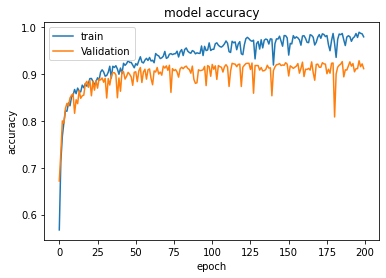

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()